In [320]:
from lib.models import *
from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader
import torch
from torch import nn
from tqdm import tqdm
from lib.utils import cms,test_evaluation
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
import plotly.express as px
import pandas as pd
from lib.utils import get_bout_statistics_for_predictions
import numpy as np
import seaborn as sns
device = 'cuda'
model = BigPapa().to(device)
model.load_state_dict(torch.load('84.pt',map_location='cuda'))

params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)
data_dir = 'w9_centered'
trainloader = DataLoader(Dataset2p0(dir=f'{data_dir}/train/',labels=f'{data_dir}/y_train.pt'),batch_size=32,shuffle=True)
devloader = DataLoader(Dataset2p0(dir=f'{data_dir}/dev/',labels=f'{data_dir}/y_dev.pt'),batch_size=32,shuffle=True)
testloader = DataLoader(Dataset2p0(dir=f'{data_dir}/test/',labels=f'{data_dir}/y_test.pt'),batch_size=32,shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Params:  10286


In [2]:
train = iter(trainloader)
embs = torch.Tensor()
ys = torch.Tensor()

In [286]:

X,y = next(train)
embedding = model.resnet(X[:,20000:25000].cuda(),classification=False)
embs = torch.cat([embs,embedding.detach().cpu()])
ys = torch.cat([ys,y])

In [323]:

from sklearn.manifold import TSNE
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components,learning_rate='auto',init='pca')
tsne_result = tsne.fit_transform(embs.detach().cpu())
df = pd.DataFrame(tsne_result)
df['label'] = ys.argmax(axis=1)

/home/andrew/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


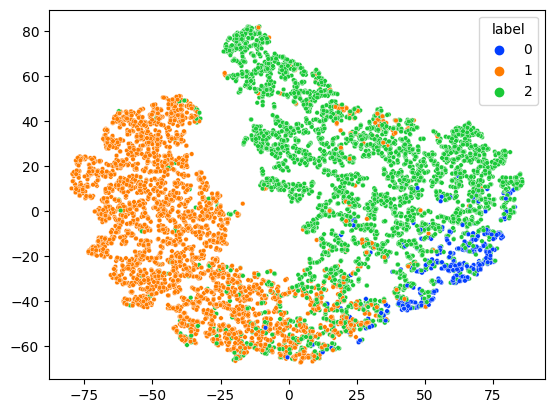

In [324]:

import seaborn as sns
sns.scatterplot(data=df,x=0,y=1,hue='label',s=11,palette=sns.color_palette('bright',n_colors=3))

plt.xlabel('')
plt.ylabel('')
plt.savefig('tsne.svg')

In [ ]:
plt.figure(figsize=(7.2,4.45))
plt.plot(next(iter(trainloader))[0][0][:5000])
plt.savefig('out.svg')

In [ ]:
test_evaluation(trainloader,model,criterion)

In [ ]:
test_evaluation(devloader,model,criterion)

100%|██████████| 1819/1819 [01:36<00:00, 18.82it/s]


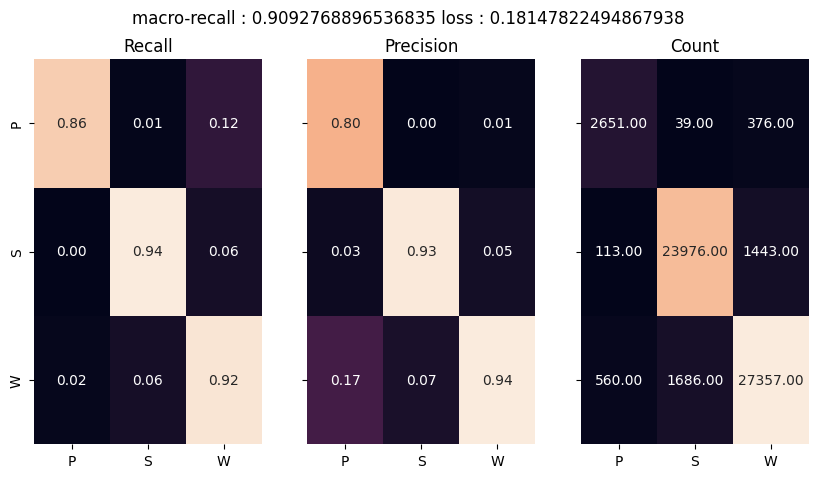

In [308]:
loss,y_true,y_pred = test_evaluation(testloader,model,criterion)

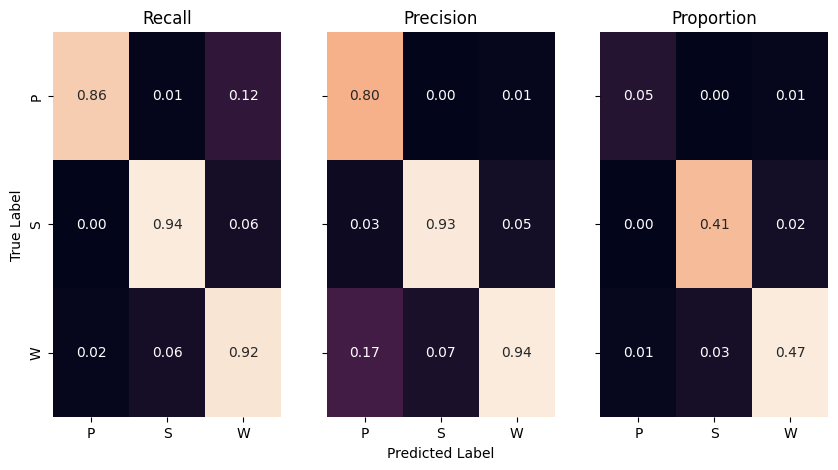

In [318]:
from sklearn.metrics import confusion_matrix
fig,axes = plt.subplots(1,3,sharey=True,figsize=(10,5))
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true'),annot=True,ax=axes[0],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,ax=axes[1],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='all'),annot=True,ax=axes[2],cbar=False,fmt='.2f')
axes[0].set_title('Recall')
axes[1].set_title('Precision')
axes[2].set_title('Proportion')
axes[0].set_xticklabels(['P','S','W'])
axes[1].set_xticklabels(['P','S','W'])
axes[2].set_xticklabels(['P','S','W'])
axes[0].set_yticklabels(['P','S','W'])
axes[0].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
plt.savefig('cm.svg')

In [ ]:
# evaluate single holdout
X,y = torch.load(f'{data_dir}/holdout_18.pt')
holdoutloader = DataLoader(TensorDataset(X,y),batch_size=32)
loss,y_true,y_pred = test_evaluation(holdoutloader,model,criterion)

pred_expert = np.array(y_pred).copy()

for j in range(len(pred_expert)-2):
    if(pred_expert[j+1] != pred_expert[j] and pred_expert[j+1] != pred_expert[j+2]):
        pred_expert[j+1] = pred_expert[j]
df = pd.DataFrame([y_true.numpy(),y_pred.detach().cpu().numpy(),pred_expert],index=['true','pred','expert']).T

df.loc[df['true'] == 2,'true'] = 'W'
df.loc[df['true'] == 1,'true'] = 'S'
df.loc[df['true'] == 0,'true'] = 'P'
df.loc[df['pred'] == 2,'pred'] = 'W'
df.loc[df['pred'] == 1,'pred'] = 'S'
df.loc[df['pred'] == 0,'pred'] = 'P'
df.loc[df['expert'] == 2,'expert'] = 'W'
df.loc[df['expert'] == 1,'expert'] = 'S'
df.loc[df['expert'] == 0,'expert'] = 'P'

# cms(y_true=y_true,y_pred=pred_expert)

In [ ]:
fig = px.line(data_frame=df,y=['true','expert'])
fig.show(renderer='browser')

In [ ]:
stats_pred = get_bout_statistics_for_predictions(df['pred'])
stats_pred

In [ ]:
stats_true = get_bout_statistics_for_predictions(df['true'])
stats_true

In [ ]:
(stats_true-stats_pred)/stats_true

100%|██████████| 270/270 [00:10<00:00, 25.30it/s]


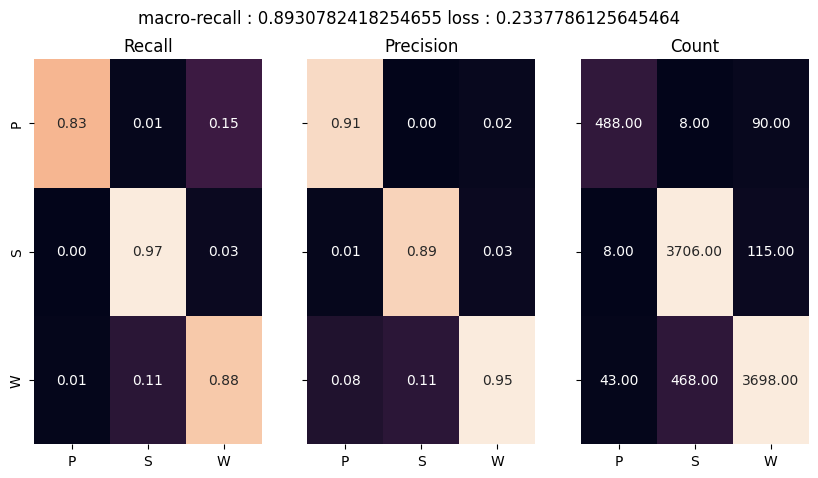

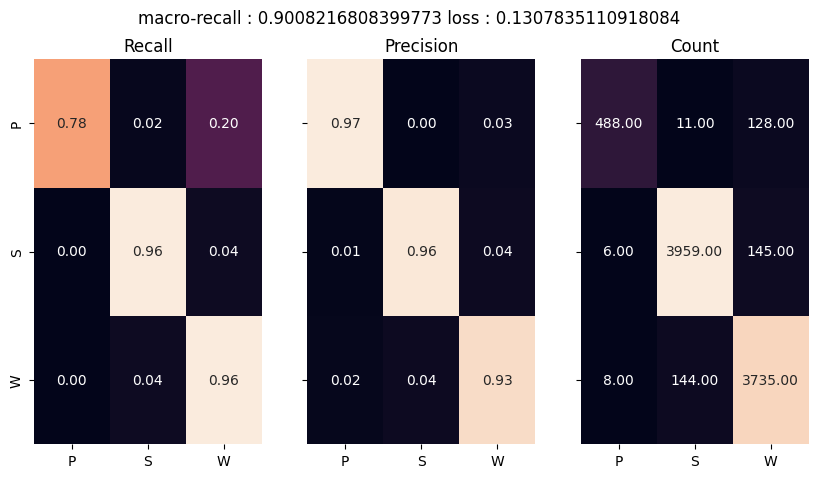

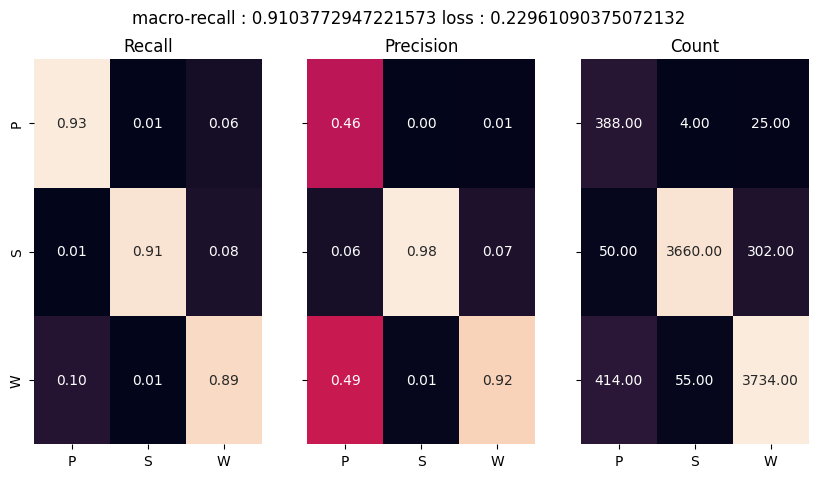

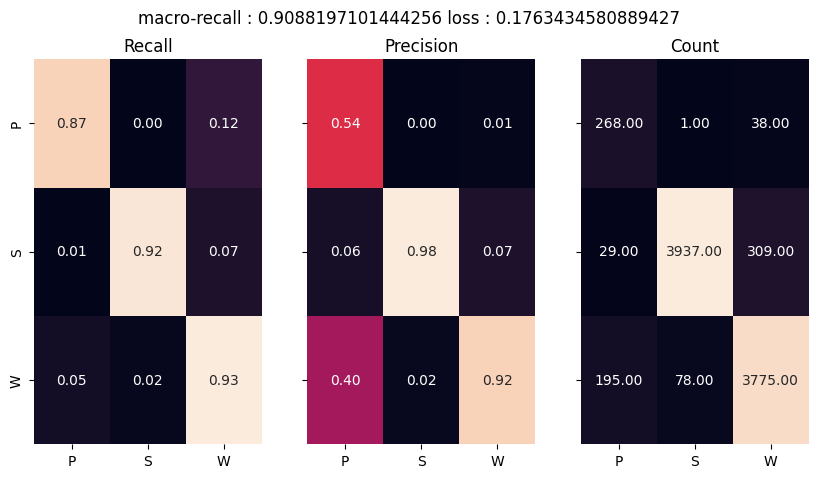

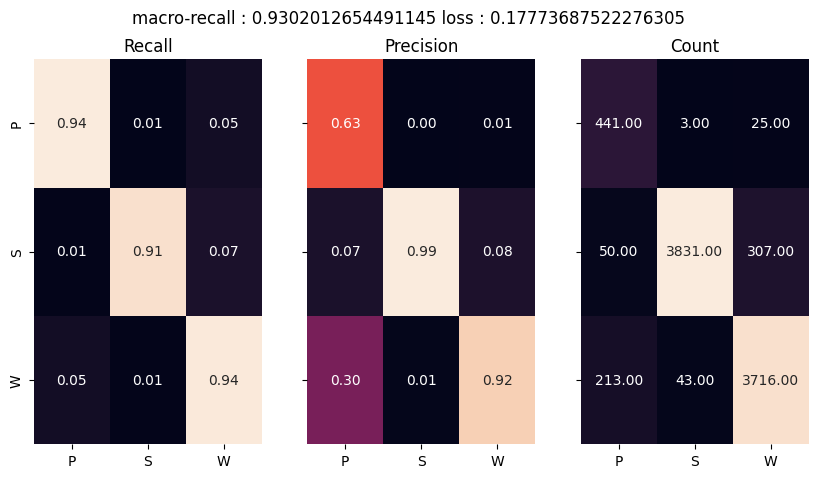

In [306]:
# evaluate single holdout
from sklearn.metrics import recall_score,precision_score,f1_score

holdout_idx = [18, 7, 13, 16, 12]
recalls = []
precisions = []
f1s = []
stats_true = pd.DataFrame()
stats_pred = pd.DataFrame()
for idx in holdout_idx:
    X,y = torch.load(f'{data_dir}/holdout_{idx}.pt')
    holdoutloader = DataLoader(TensorDataset(X,y),batch_size=32)
    loss,y_true,y_pred = test_evaluation(holdoutloader,model,criterion)

    pred_expert = np.array(y_pred).copy()

    for j in range(len(pred_expert)-2):
        if(pred_expert[j+1] != pred_expert[j] and pred_expert[j+1] != pred_expert[j+2]):
            pred_expert[j+1] = pred_expert[j]
    df = pd.DataFrame([y_true.numpy(),y_pred.detach().cpu().numpy(),pred_expert],index=['true','pred','expert']).T

    df.loc[df['true'] == 2,'true'] = 'W'
    df.loc[df['true'] == 1,'true'] = 'S'
    df.loc[df['true'] == 0,'true'] = 'P'
    df.loc[df['pred'] == 2,'pred'] = 'W'
    df.loc[df['pred'] == 1,'pred'] = 'S'
    df.loc[df['pred'] == 0,'pred'] = 'P'
    df.loc[df['expert'] == 2,'expert'] = 'W'
    df.loc[df['expert'] == 1,'expert'] = 'S'
    df.loc[df['expert'] == 0,'expert'] = 'P'
    stats_predi = get_bout_statistics_for_predictions(df['pred'])
    stats_truei = get_bout_statistics_for_predictions(df['true'])

    stats_pred = pd.concat([stats_pred,stats_predi.reset_index().melt(id_vars='index')])
    stats_true = pd.concat([stats_true,stats_truei.reset_index().melt(id_vars='index')])

    recall = recall_score(y_true=y_true,y_pred=y_pred,average='macro')
    precision = precision_score(y_true=y_true,y_pred=y_pred,average='macro')
    f1 = f1_score(y_true=y_true,y_pred=y_pred,average='macro')
    recalls.append(recall)
    precisions.append(precision)
    f1s.append(f1)

In [307]:
print(f1s)
print(torch.tensor(f1s).mean())
print(torch.tensor(f1s).std())
print(recalls)
print(torch.tensor(recalls).mean())
print(torch.tensor(recalls).std())
print(precisions)
print(torch.tensor(precisions).mean())
print(torch.tensor(precisions).std())

[0.9015063558372086, 0.9244807107278085, 0.8206737119946427, 0.8482185513795178, 0.8762108161594867]
tensor(0.8742, dtype=torch.float64)
tensor(0.0413, dtype=torch.float64)
[0.8930782418254655, 0.9008216808399773, 0.9103772947221573, 0.9088197101444256, 0.9302012654491145]
tensor(0.9087, dtype=torch.float64)
tensor(0.0139, dtype=torch.float64)
[0.9130118320074049, 0.9554405179379902, 0.786337514142449, 0.8136205655675385, 0.8441799334390887]
tensor(0.8625, dtype=torch.float64)
tensor(0.0702, dtype=torch.float64)


In [ ]:
stats_pred['type'] = 'pred'
stats_true['type'] = 'true'

stats = pd.concat([stats_pred,stats_true])
sns.displot(data=stats.reset_index(drop=True),x='value',hue='type',col='index',row='variable',kind='kde')
plt.savefig('ot.jpg')

In [ ]:
stats_true.loc[(stats_true['index'] == 'total'),'value'] = abs(stats_true[(stats_true['index'] == 'total')]['value']-stats_pred[(stats_pred['index'] == 'total')]['value'])/(stats_true[(stats_true['index'] == 'total')]['value'])

In [ ]:
stats_true.loc[(stats_true['index'] == 'average'),'value'] = abs(stats_true[(stats_true['index'] == 'average')]['value']-stats_pred[(stats_pred['index'] == 'average')]['value'])/(stats_true[(stats_true['index'] == 'average')]['value'])

In [ ]:
stats_true.loc[(stats_true['index'] == 'counts'),'value'] = abs(stats_true[(stats_true['index'] == 'counts')]['value']-stats_pred[(stats_pred['index'] == 'counts')]['value'])/(stats_true[(stats_true['index'] == 'counts')]['value'])

In [ ]:
sns.kdeplot(data=stats_true.loc[(stats_true['index'] == 'counts')].reset_index(drop=True),x='value',hue='variable')